# **Project Task 2**

**Akshay Shukla - 2022A7PS0087P**

**Ishaan Kale - 2022A7PS0084P**

**Siddhartha Gotur - 2022A7PS0070P**

In [10]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2


In [11]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [12]:
import zipfile

!unzip /content/flower_dataset.zip

unzip:  cannot find or open /content/flower_dataset.zip, /content/flower_dataset.zip.zip or /content/flower_dataset.zip.ZIP.


**Data Loading**

In [13]:
train_dir = "./train_data"
val_dir = "./val_data"
train_labels_path = "./train_labels.txt"
val_labels_path = "./val_labels.txt"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

In [14]:
def load_labels(labels_path):
    with open(labels_path, 'r') as f:
        labels = [int(line.strip()) for line in f.readlines()]
    return labels

train_labels = load_labels(train_labels_path)
val_labels = load_labels(val_labels_path)

# Get file paths
train_images = sorted([os.path.join(train_dir, img) for img in os.listdir(train_dir) if img.endswith('.jpg')])
val_images = sorted([os.path.join(val_dir, img) for img in os.listdir(val_dir) if img.endswith('.jpg')])

# Ensure the number of images matches the number of labels
assert len(train_images) == len(train_labels), "Mismatch in training images and labels!"
assert len(val_images) == len(val_labels), "Mismatch in validation images and labels!"

**Data Preprocessing**

In [15]:
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    IMAGENET_MEAN = [123.68, 116.779, 103.939]
    IMAGENET_STD = [58.393, 57.12, 57.375]
    mean = tf.constant(IMAGENET_MEAN, dtype=tf.float32)
    std = tf.constant(IMAGENET_STD, dtype=tf.float32)
    image = (image - mean) / std
    return image, tf.one_hot(label, 60)


# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)



**Data Visualisation**

Visualizing training data...


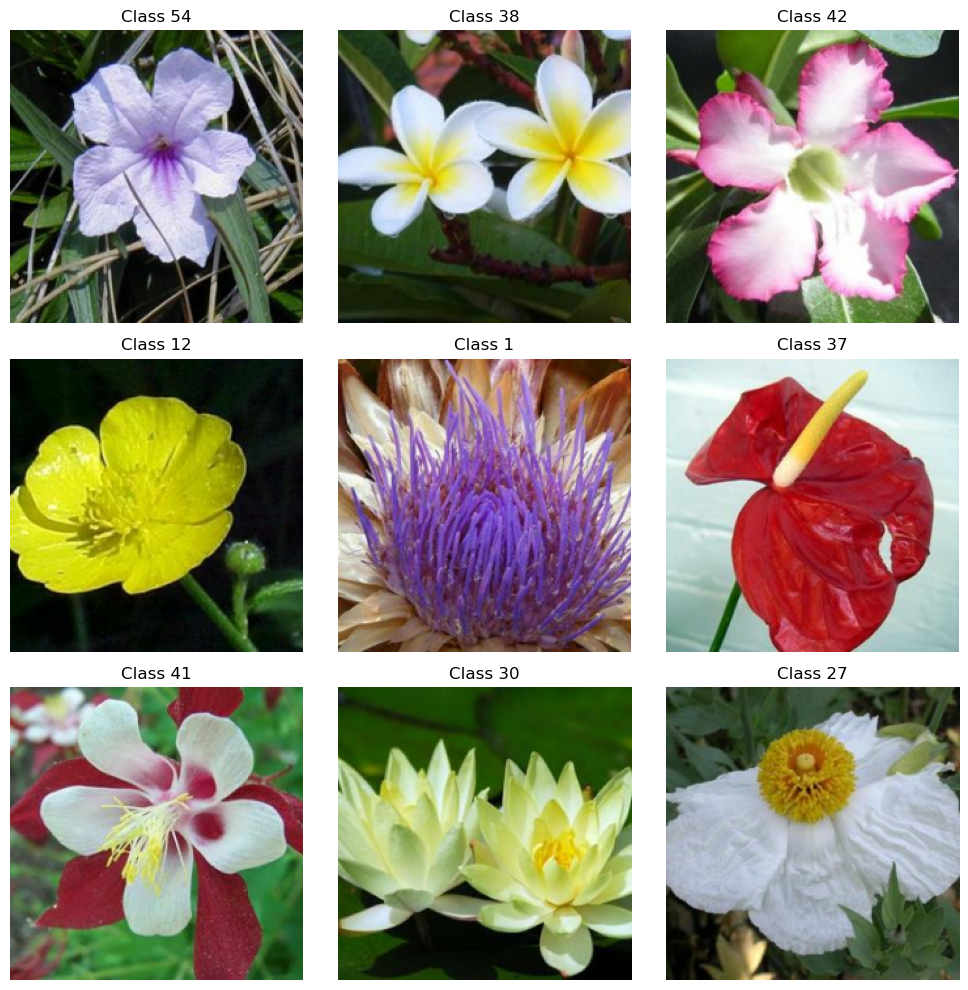

In [16]:
def visualize_data(images, labels, label_mapping, num_samples=9):
    plt.figure(figsize=(10, 10))
    indices = tf.random.shuffle(tf.range(len(images)))[:num_samples]
    for i, idx in enumerate(indices):
        img = tf.io.read_file(images[idx])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0  # Normalize

        plt.subplot(int(num_samples**0.5), int(num_samples**0.5), i + 1)
        plt.imshow(img)
        plt.title(label_mapping[labels[idx]])  # Directly use labels[idx] instead of .numpy()
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Create label mapping for visualization
unique_labels = sorted(set(train_labels))  # Get unique class labels
label_mapping = {i: f"Class {i}" for i in unique_labels}

print("Visualizing training data...")
visualize_data(train_images, train_labels, label_mapping)


**Model Definition**

In [17]:
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False  # Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='leaky_relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(60, activation='softmax')
])


**Model Training**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    verbose=1)
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    verbose=1)

Epoch 1/10
94/94 [==============================] - 216s 2s/step - loss: 7.6519 - accuracy: 0.1910 - val_loss: 6.2092 - val_accuracy: 0.4467
Epoch 2/10
30/94 [========>.....................] - ETA: 2:03 - loss: 5.5076 - accuracy: 0.5750

In [ ]:
# Save the model weights
model.save_weights("flower_model.weights.h5")

In [ ]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

**Function for testing the model**

In [ ]:
import tensorflow as tf
import os
import numpy as np

#Model architecture
def create_model():
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(60, activation='softmax')
    ])
    model.build(input_shape=(None, 224, 224, 3))

    return model

# Load the model weights
model = create_model()
model.load_weights("./flower_model.weights.h5")

# Load and preprocess validation data
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    IMAGENET_MEAN = [123.68, 116.779, 103.939]
    IMAGENET_STD = [58.393, 57.12, 57.375]
    mean = tf.constant(IMAGENET_MEAN, dtype=tf.float32)
    std = tf.constant(IMAGENET_STD, dtype=tf.float32)
    image = (image - mean) / std
    return image, tf.one_hot(label, 60)

test_dir = "./val_data"  # Replace with actual validation data directory
test_labels_path = "./val_labels.txt"  # Replace with actual validation labels path

test_images = sorted([os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith('.jpg')])
with open(test_labels_path, 'r') as f:
    test_labels = [int(line.strip()) for line in f.readlines()]

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(lambda img, label: (preprocess_image(img, label))).batch(32) # Assuming BATCH_SIZE is 32

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Evaluate the model
loss, accuracy = model.evaluate(test_ds, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")